# Exercise 2: Data set, augmentation, and baseline
## Goals:
- Explore data
- Augment data
- Train a simple model and evaluate the effect of using augmented data


In this exercise we are going to explore how augmented data can be used in training and testing.

The code used in the exercise is based on the code already shown during the lecture. In this notebook you get the main code blocks to do the exercise. It helps to look at the code to get inspiration to solve the exercise. 

In [2]:
import numpy as np
import pandas as pd
import skimage.io as io
import matplotlib.pyplot as plt
import os

## Load data
In this execercise we will be working with a CT data set from lungs which are acompanied by a list of labels to tell if the image is healthy or malign. The image slices are stored in a (3D) numpy array and the labels in a pandas data frame. [Pandas](https://pandas.pydata.org/docs/) is a libray that helps you to store tables of data that are searchable and slicable depending on different criteria.

__Note:__ Please uncompress the file ```ct_tiles.tif.zip``` before starting.

In [3]:
path = os.getcwd()

# chage directory to 02-Files
os.chdir(path + '/02-Files')

In [4]:
imgs = io.imread('ct_tiles.tif')
labels = pd.read_csv('malignancy.csv')
print('Image size: {0},{1},{2}'.format(imgs.shape[0],imgs.shape[1],imgs.shape[2]))
print('Labels {0}'.format(labels.malignancy.count() ))

Image size: 6691,64,64
Labels 6691


## What is the first thing to do after loading the data?

# Explore the data

### Look at the label distribution

<Axes: >

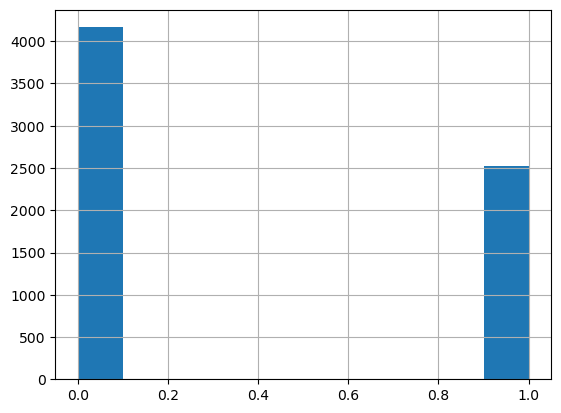

In [5]:
# TODO: What can we observe in the label distribution? slihtly imbalanced but not too bad. 
labels.malignancy.hist()

In [6]:
labels.malignancy.describe()

count    6691.000000
mean        0.377522
std         0.484803
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: malignancy, dtype: float64

In [7]:
y = labels.malignancy.values
y.shape

(6691,)

### Look at some slices

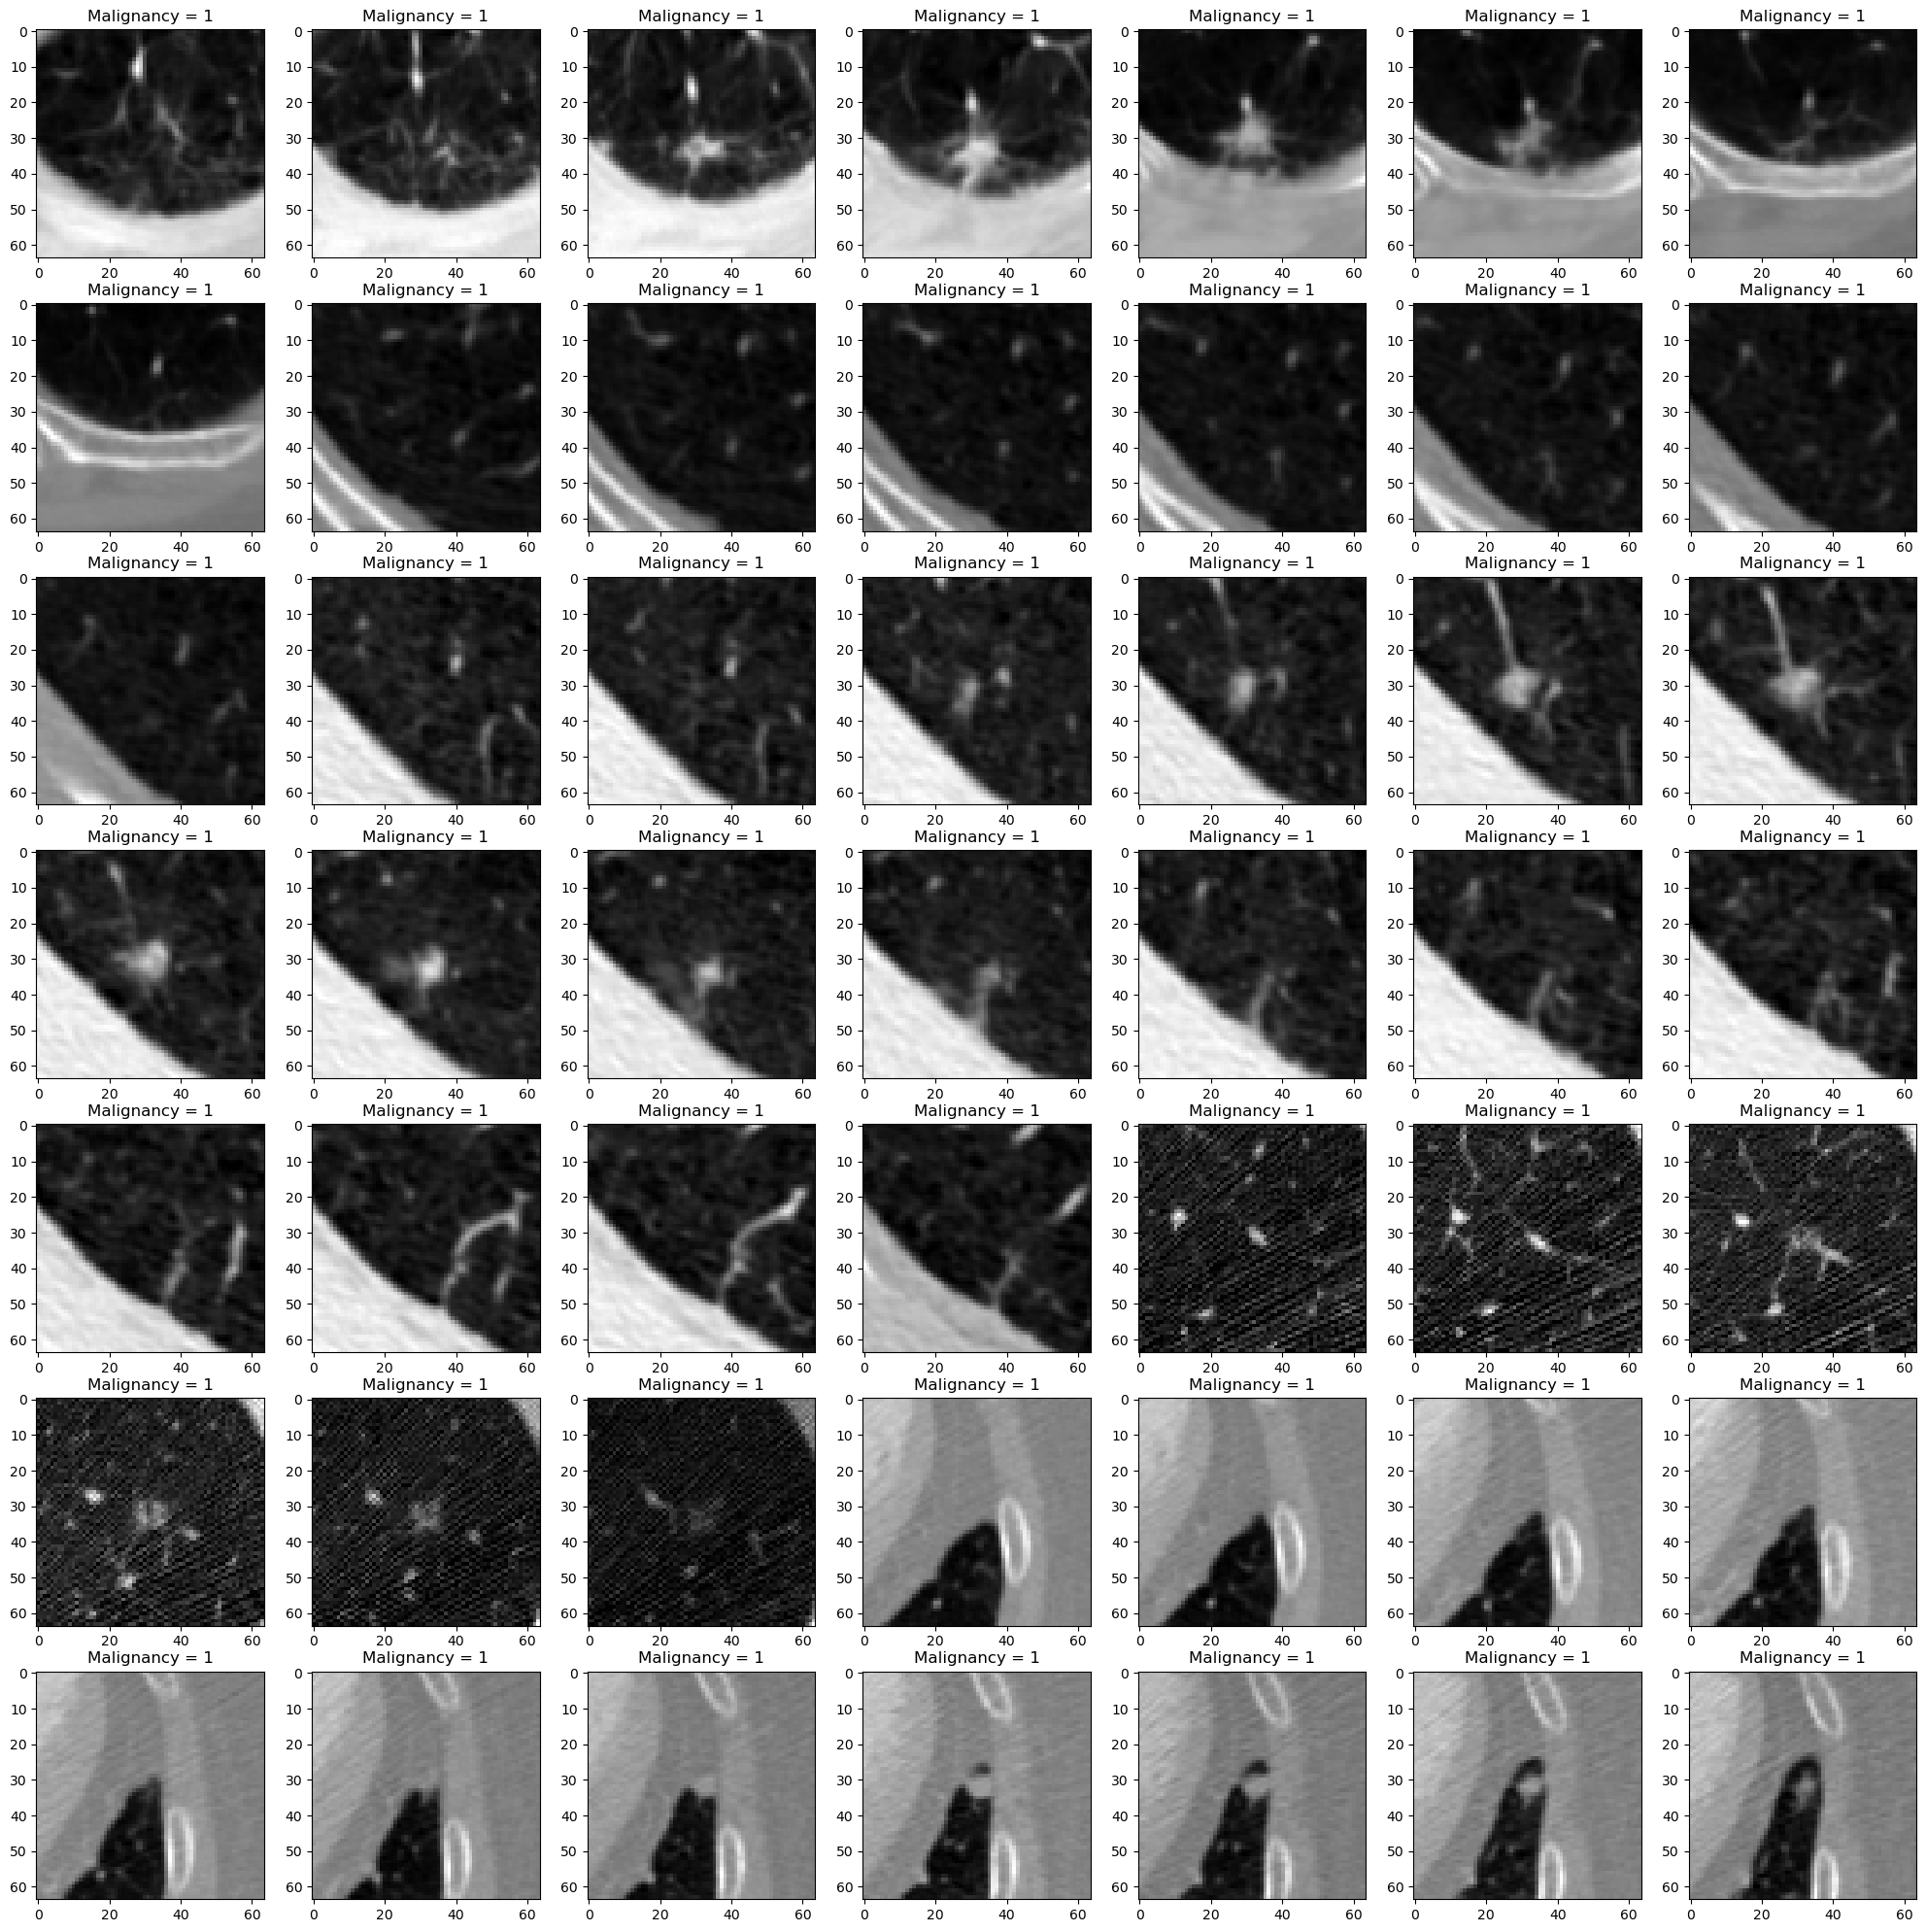

In [8]:
# TODO: What can we observe in the data array? malignant 
LABEL = 1
r = slice(0,49) if LABEL == 1 else slice(-49,None)
plt.figure(figsize=[25,25])
for idx,tile in enumerate(imgs[r]) :
    plt.subplot(7,7,idx+1)
    plt.imshow(tile, cmap='gray') ;
    i = idx if LABEL == 1 else -49 + idx
    plt.title('Malignancy = {0}'.format(y[i]))

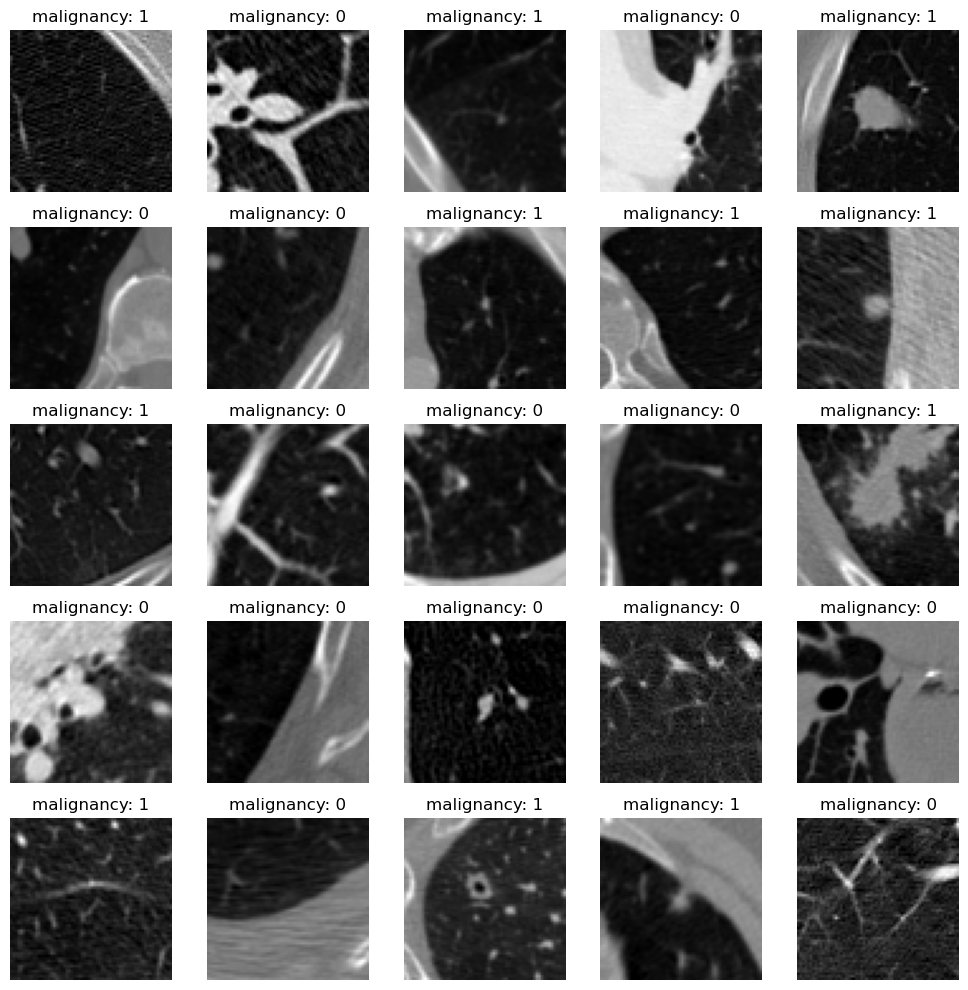

In [9]:

def plot_sample_images(images, labels, n=25):
    plt.figure(figsize=(10, 10))
    
    indices = np.random.choice(len(images), n, replace=False)  # Randomly select n images
    selected_images = images[indices]
    selected_labels = labels[indices]
    
    grid_size = int(n ** 0.5)  # Create a square grid
    for i, (img, label) in enumerate(zip(selected_images, selected_labels)):
        plt.subplot(grid_size, grid_size, i + 1)
        plt.imshow(img, cmap='gray')  # Use 'gray' for single-channel images
        plt.title(f"malignancy: {str(label)}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Assuming your images are stored in `X` and labels in `y`
plot_sample_images(imgs, y)


## Augmenting the data
Let's create a data augmentation pipeline. The full range of readily available augmentations can be found here: https://github.com/albumentations-team/albumentations?tab=readme-ov-file#list-of-augmentations
We will be working with some simple augmentations like:
- rotation
- translation
- scaling
- shear
- flips
- blurring
- etc.

In [10]:
import albumentations as A

# Define an augmentation pipeline
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    # A.RandomBrightnessContrast(p=0.2),
    A.RandomCrop(width=50, height=50),
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=0, p=0.5),  # Width & height shift, zoom
    A.Affine(shear=(-20, 20), p=0.5),  # Shear transformation
    A.GaussianBlur(p=0.2),
    A.Normalize(mean=(0.5,), std=(0.5,)),  # Normalize images
])


/opt/anaconda3/envs/quant_img/lib/python3.10/site-packages/albumentations/core/validation.py:58: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


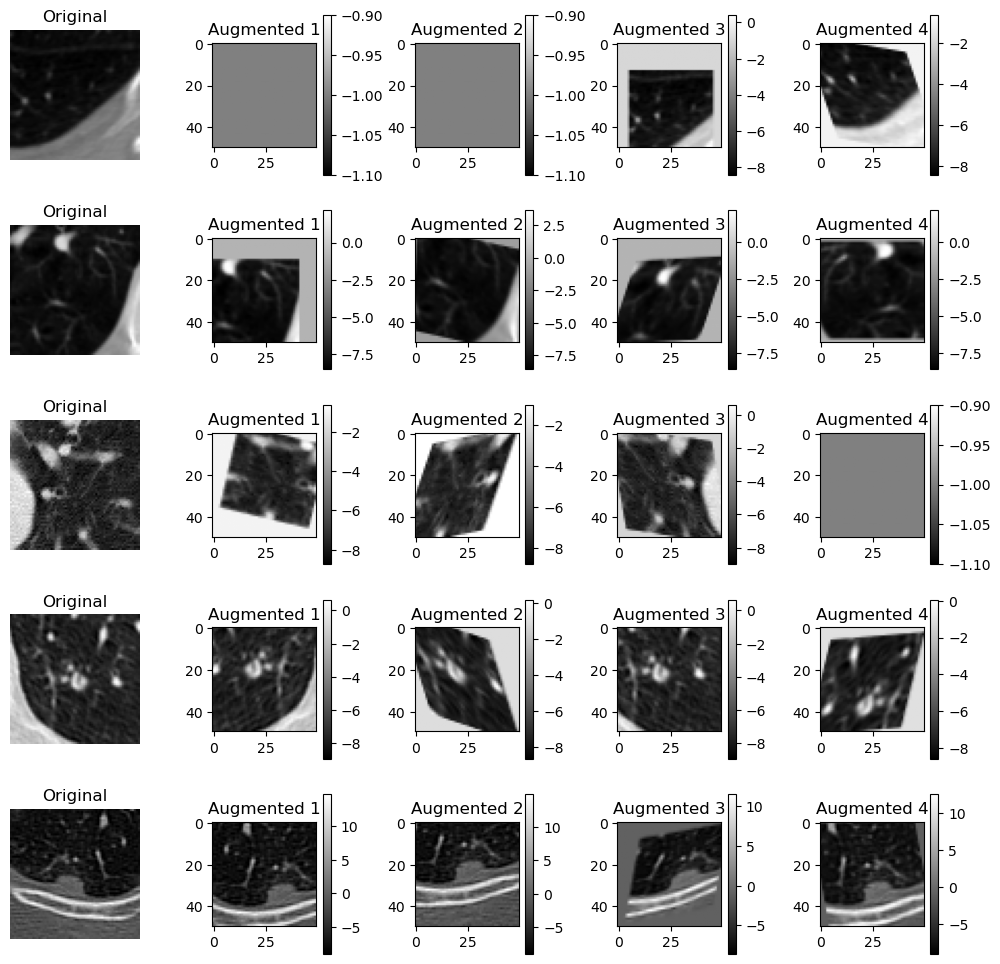

In [11]:
# GIven a set of images, plot the image and in the same row plot 4 augmentations of the image
def plot_augmented_images(images, transform: A.Compose, n=5):
    plt.figure(figsize=(10, 10))
    
    indices = np.random.choice(len(images), n, replace=False)  # Randomly select n images
    selected_images = images[indices]
    
    grid_size = int(n ** 0.5)  # Create a square grid
    for i, img in enumerate(selected_images):
        plt.subplot(n, 5, i * 5 + 1)
        plt.imshow(img, cmap='gray')
        plt.title("Original")
        plt.axis('off')
        
        for j in range(4):
            transformed = transform(image=img)
            transformed_image = transformed["image"]
            plt.subplot(n, 5, i * 5 + j + 2)
            plt.imshow(transformed_image, cmap='gray')
            plt.title(f"Augmented {j + 1}")
            plt.colorbar()
            # plt.axis('off')

    plt.tight_layout()
    plt.show()

# Assuming your images are stored in `X`
plot_augmented_images(imgs, transform, n=5)
        

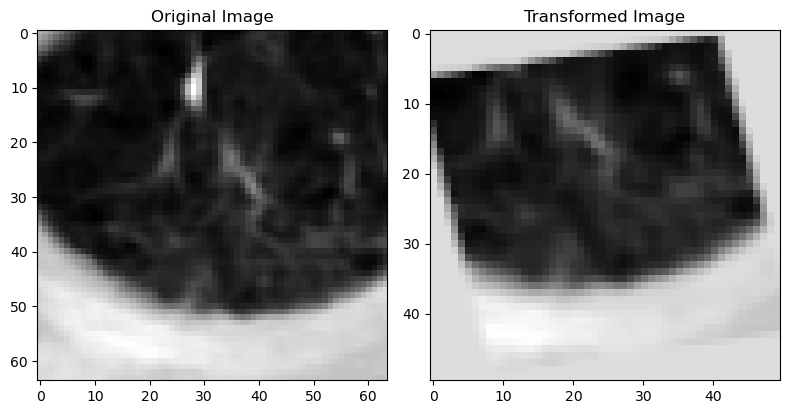

In [12]:
# TODO: WHich transformations do you see?
im = imgs[0]
transformed = transform(image=im)
transformed_image = transformed["image"]

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(im, cmap='gray')
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(transformed_image, cmap='gray')
plt.title("Transformed Image")

plt.tight_layout()
plt.show()



In [13]:
transform = A.Compose([
        A.RandomCrop(width=64, height=64, p = 1),
        A.HorizontalFlip(p=0.5),
        #A.VerticalFlip(p=0.5)
        #A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.3),
        #A.GaussianBlur(blur_limit=(3, 3), p=0.1),
        #A.Normalize(mean=(0.5,), std=(0.5,)),  # Normalize images
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=5, p=0.5),
    ])

In [15]:
import cv2
transform = A.Compose([
    # Only apply random crop if your original images are larger than 64x64.
    # If they're exactly 64x64, remove this step.
    # A.RandomCrop(width=60, height=60, p=0.5),
    
    # Mild flips - remove vertical flip if it doesn't make sense medically
    A.HorizontalFlip(p=0.5),
    
    # Gentle shift/scale/rotate, with reflective border
    A.ShiftScaleRotate(
        shift_limit=0.05, scale_limit=0.1, rotate_limit=5,
        border_mode=cv2.BORDER_REFLECT_101,  # avoids black corners
        p=0.5
    ),
    
    # Mild brightness/contrast
    #A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.3),
    
    # Optional mild blur
    #A.GaussianBlur(blur_limit=(3, 3), p=0.1),
    
    # Normalize last
    #A.Normalize(mean=(0.5,), std=(0.5,)),
])

/opt/anaconda3/envs/quant_img/lib/python3.10/site-packages/albumentations/core/validation.py:58: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


## This is much better

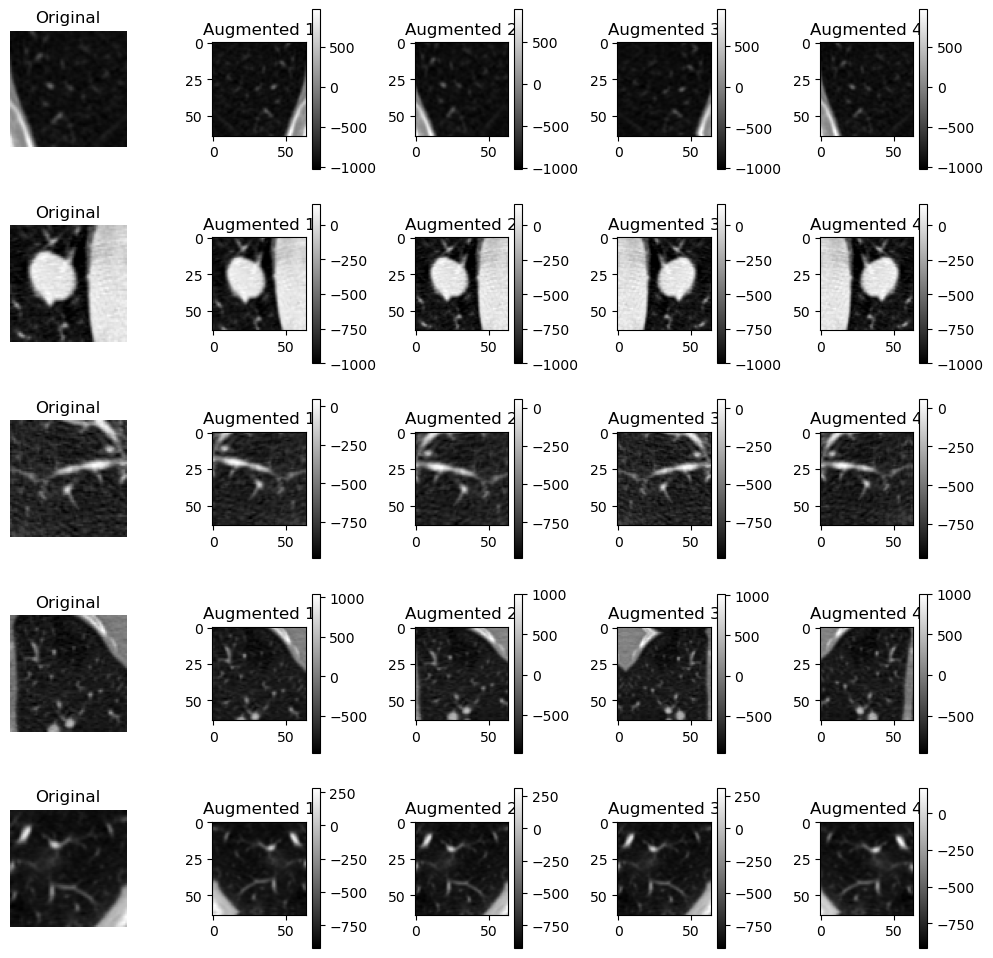

In [16]:
# GIven a set of images, plot the image and in the same row plot 4 augmentations of the image
def plot_augmented_images(images, transform: A.Compose, n=5):
    plt.figure(figsize=(10, 10))
    
    indices = np.random.choice(len(images), n, replace=False)  # Randomly select n images
    selected_images = images[indices]
    
    grid_size = int(n ** 0.5)  # Create a square grid
    for i, img in enumerate(selected_images):
        plt.subplot(n, 5, i * 5 + 1)
        plt.imshow(img, cmap='gray')
        plt.title("Original")
        plt.axis('off')
        
        for j in range(4):
            transformed = transform(image=img)
            transformed_image = transformed["image"]
            plt.subplot(n, 5, i * 5 + j + 2)
            plt.imshow(transformed_image, cmap='gray')
            plt.title(f"Augmented {j + 1}")
            plt.colorbar()
            # plt.axis('off')

    plt.tight_layout()
    plt.show()

# Assuming your images are stored in `X`
plot_augmented_images(imgs, transform, n=5)
        

## Testing baselines with augmented data
From the lectures you learned that in order to compare the performance of an algorithm, you need a baseline algorithm. Previously, you heard about two algorithms:
- Dummy classifier which uses the majority as prediction for any input data.
- Nearest neighbor that uses the nearest feature as prediction.

Below you get examples on the lung data.

### Dummy classifier

In [ ]:
from sklearn.dummy import DummyClassifier
dc = DummyClassifier(strategy='most_frequent')
dc.fit(imgs, y)

DummyClassifier(strategy='most_frequent')

In [ ]:
predictions = dc.predict(imgs)


### How to evaluate performance? Metrics:
- Accuracy
- Precision
- F1 score
- ...
- Quite comprehensive list: https://scikit-learn.org/stable/api/sklearn.metrics.html
Use case dependent!

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y, predictions)

0.6224779554625617

(array([   0.,    0.,    0.,    0.,    0., 6691.,    0.,    0.,    0.,
           0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <BarContainer object of 10 artists>)

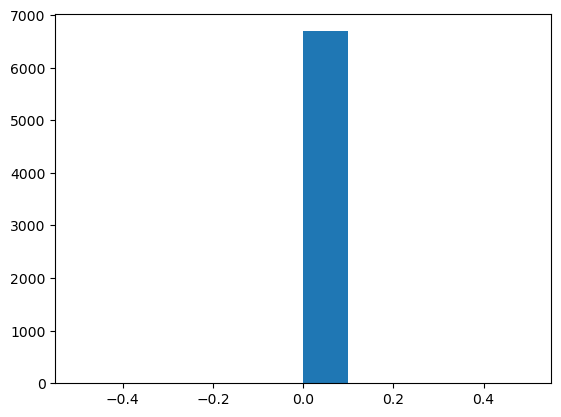

In [ ]:
plt.hist(predictions)

In [ ]:
1 - y.sum() / len(y)

0.6224779554625617

### Nearest neighbor

In [ ]:
# TODO: Why do we reshape the images? What is the resulting shape? KNN classifier needs 2D data for input (we are reducing the dimension to 2D here)
from sklearn.neighbors import KNeighborsClassifier
neigh_class = KNeighborsClassifier(n_neighbors=1)
reshaped_imgs = imgs.reshape(imgs.shape[0], -1)
neigh_class.fit(reshaped_imgs, y)

KNeighborsClassifier(n_neighbors=1)

(array([4165.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        2526.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

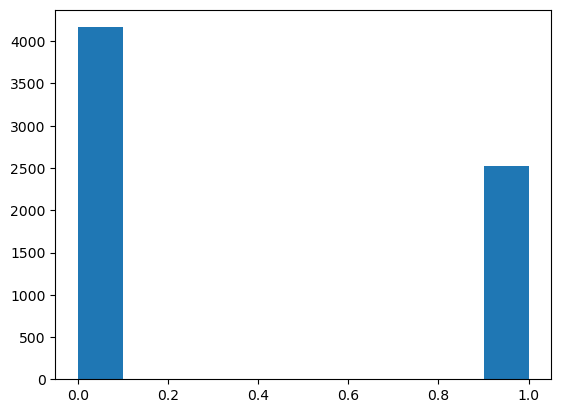

In [ ]:
# predict on a few images
preds = neigh_class.predict(reshaped_imgs)
plt.hist(preds)

### Confusion matrix

In [ ]:
import seaborn as sns
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Stolen from: https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig, ax1 = plt.subplots(1, 1, figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return ax1

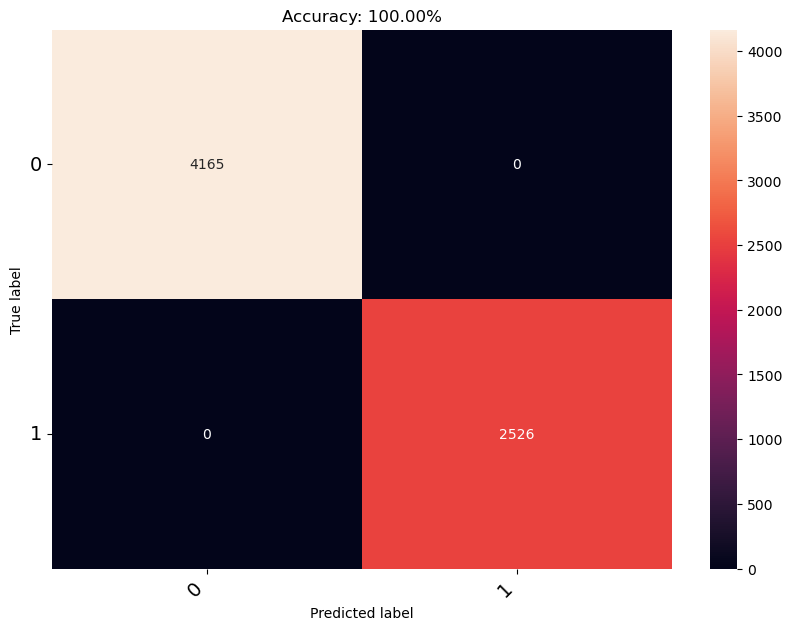

In [ ]:
pred_values = neigh_class.predict(reshaped_imgs)
ax1 = print_confusion_matrix(confusion_matrix(y, pred_values), class_names=range(2))
ax1.set_title('Accuracy: {:2.2%}'.format(accuracy_score(y, pred_values)));

## Why did we get perfect accuracy? 
## What happens if we use K!=1?
> Cause we didn't differentiate the training dataset and the test dataset for training and testing


we take the majority then, so more robust to the noise and generalized better than 1 (less overfitting and less sensitive to the outliers)

## Exercise
1. Evaluate the nearest neighbour baseline "properly" in this notebook.
Complete the functions in `tasks.py` and pass the tests. You will have to:
2. Create a subset of the original datasets with 500 images. Create an augmented data set of 2500 images from the selected subset. Pay attention to obtaining a representative balance between healthy and malign samples. The augmented images should be of size 64,64.
3. Fit a KNNs classifier using 
    1. the original subset of 500 data samples. You should achieve >60% accuracy.
    2. the augmented dataset. You should achieve >70% accuracy.
    > Note: You will have to play with the number, type and hyperparameters of the augmentations and the kNN classifier.
    > Note: You will have to implement the functions to train, predict and evaluate the kNN model.
4. Compare the performance using the confusion matrix. Plot it on this notebook.

> Tip: Solve each of the tasks first on the notebook, so it is easier to see the input and output of the functions. Check the file `test_exercise2.py` and the docstrings of each function to get more information on how to implement them.

In [ ]:
import os
os.chdir('/Users/sunhokim/Desktop/ETHZ/2025_S/Quant_big_img/Exercise/qbi2025-ex2-sunhollyjolly/exercise')
print(os.getcwd())  

/Users/sunhokim/Desktop/ETHZ/2025_S/Quant_big_img/Exercise/qbi2025-ex2-sunhollyjolly/exercise


In [ ]:
import tasks

In [ ]:
labels

,idx,malignancy
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1
...,...,...
6686,6686,0
6687,6687,0
6688,6688,0
6689,6689,0


In [ ]:
# Extract the actual label column from the DataFrame
labels = labels['malignancy'].to_numpy()

In [ ]:
labels

array([1, 1, 1, ..., 0, 0, 0])

(500, 64, 64) (500,) (2500, 64, 64) (2500,)
Accuracy on the 500 set: 0.6579536967886482
Accuracy on the augmented set: 0.44286781179985063


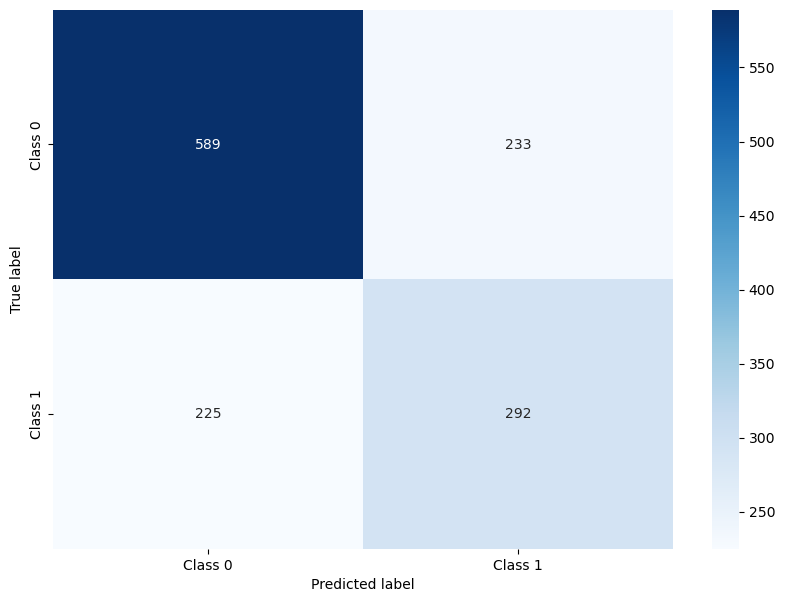

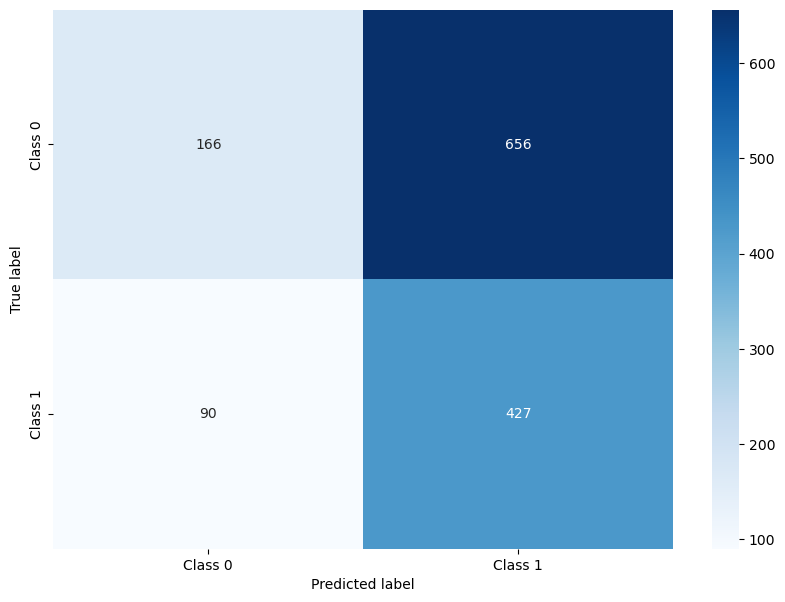

In [ ]:
if __name__ == '__main__':

    # Split first (e.g., 80% training, 20% testing)
    train_data, test_data, train_labels, test_labels = tasks.split_train_test_dataset(imgs, labels)

    # Pick out 500 imgs
    subset_data, subset_labels = tasks.create_dataset_subset(train_data, train_labels, 500)

    # augment on this
    augmented_data, augmented_labels = tasks.augment_data(subset_data, subset_labels)

    # check the shape
    print(subset_data.shape, subset_labels.shape, augmented_data.shape, augmented_labels.shape)

    # Train on the 500 imgs 
    knn_model_500 = tasks.train_kNN(subset_data, subset_labels, k=10)
    predict_500 = tasks.predict_kNN(knn_model_500, test_data)
    accuracy_500 = tasks.evaluate_predictions(test_labels, predict_500, accuracy_score)
    print("Accuracy on the 500 set:", accuracy_500)

    # Train on the 2500 imgs
    knn_model_2500 = tasks.train_kNN(augmented_data, augmented_labels, k=10)
    predict_2500 = tasks.predict_kNN(knn_model_2500, test_data)
    accuracy_2500 = tasks.evaluate_predictions(test_labels, predict_2500, accuracy_score)
    print("Accuracy on the augmented set:", accuracy_2500)

    # Plot the confusion matrix
    tasks.plot_confusion_matrix(test_labels, predict_500, class_names=["Class 0", "Class 1"])
    tasks.plot_confusion_matrix(test_labels, predict_2500, class_names=["Class 0", "Class 1"])

### I had issue with the augmented 2500 set showing consistently, and significantly lower accuracy than 500 set, even when I modified transform params to not aggresive ones

This could be because,,
#### (1) large black or white “padding” regions in augmented images
: I checked images are shifted beyond its boundaries and albumentations is filling the empty space with a default values or I am cropping incorrectly in a way that it leaves only background in view

#### (2) KNN doesn't learn label invariances 
: kNN classifier on raw pixels uses simple Euclidean in original pixel space and has no learnable parameters unlike DL, leaving small translation, rotation, brightness shift can drastically change pixel intensities, making two visually similar images appear far apart in raw pixel space. (purely dist-based, in the mean time, DL filters are robust to shifts, rotations and brightness changes, and more focus on the shape, edges and textures)

#### (3) having small number of k is not good for generalization
